In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
# combine all the data/usda_* into one dataframe
usda = pd.concat([pd.read_csv(f'data/usda_data_{year}.csv')  for year in range(1950, 2024)])

# combine all the data/weather_* into one dataframe
weather = pd.concat([pd.read_csv(f'data/weather_data_{year}.csv') for year in range(2000, 2021)])


In [54]:
usda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5114 entries, 0 to 57
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   class_desc             5114 non-null   object 
 1   state_alpha            5114 non-null   object 
 2   country_code           5114 non-null   int64  
 3   commodity_desc         5114 non-null   object 
 4   country_name           5114 non-null   object 
 5   short_desc             5114 non-null   object 
 6   freq_desc              5114 non-null   object 
 7   watershed_code         5114 non-null   int64  
 8   watershed_desc         0 non-null      float64
 9   year                   5114 non-null   int64  
 10  load_time              5114 non-null   object 
 11  begin_code             5114 non-null   int64  
 12  sector_desc            5114 non-null   object 
 13  CV (%)                 237 non-null    float64
 14  statisticcat_desc      5114 non-null   object 
 15  asd_code   

In [55]:
# what is the average value in udsa data for each year
usda.groupby('year')['Value'].mean()


year
1950     32.367073
1951     35.701220
1952     44.045122
1953     40.570732
1954     37.290244
           ...    
2019    138.642857
2020    143.606557
2021    164.943103
2022    151.955000
2023    158.160345
Name: Value, Length: 74, dtype: float64

I'll select the columns that I need for analysis. I will focus on year, county_name and Value.

In [56]:
# what is the average value in udsa data for each year
usda.groupby('year')['Value'].sum()

year
1950    2654.1
1951    2927.5
1952    3611.7
1953    3326.8
1954    3057.8
         ...  
2019    7764.0
2020    8760.0
2021    9566.7
2022    9117.3
2023    9173.3
Name: Value, Length: 74, dtype: float64

In [57]:
usda['year'] = pd.to_datetime(usda['year'],
               format='%Y')
usda_subset = usda[['year','county_name','Value']]

In [58]:
usda_subset['county_name'].nunique() #85 Michigan has 83

85

The result is that the data set has 85 and Michigan only has 83. The additional two are 'OTHER COUNTIES' and 'OTHER (COMBINED) COUNTIES'.

In [59]:
usda_subset_other_combined = usda_subset[usda_subset['county_name'] == 'OTHER (COMBINED) COUNTIES']
usda_subset_other_combined

,year,county_name,Value
0,1958-01-01,OTHER (COMBINED) COUNTIES,9.0
0,1960-01-01,OTHER (COMBINED) COUNTIES,46.7
1,1960-01-01,OTHER (COMBINED) COUNTIES,41.0
4,1960-01-01,OTHER (COMBINED) COUNTIES,42.9
0,1961-01-01,OTHER (COMBINED) COUNTIES,52.5
...,...,...,...
10,2019-01-01,OTHER (COMBINED) COUNTIES,110.3
17,2019-01-01,OTHER (COMBINED) COUNTIES,137.1
21,2019-01-01,OTHER (COMBINED) COUNTIES,143.2
31,2019-01-01,OTHER (COMBINED) COUNTIES,140.4


There are 144 records that contain 'OTHER (COMBINED) COUNTIES'.

In [60]:
usda_subset_other = usda_subset[usda_subset['county_name'] == 'OTHER COUNTIES']
usda_subset_other

,year,county_name,Value
60,2020-01-01,OTHER COUNTIES,151.0
57,2021-01-01,OTHER COUNTIES,150.2
59,2022-01-01,OTHER COUNTIES,163.2
57,2023-01-01,OTHER COUNTIES,166.3


	year	county_name	Value
60	2020-01-01	OTHER COUNTIES	151.0
57	2021-01-01	OTHER COUNTIES	150.2
59	2022-01-01	OTHER COUNTIES	163.2
57	2023-01-01	OTHER COUNTIES	166.3

There are 4 records (years) that contain 'OTHER COUNTIES'. We will focus on the year 2020.

In [61]:
usda_other = usda[usda['county_name'] == 'OTHER COUNTIES']
usda_other

,class_desc,state_alpha,country_code,commodity_desc,country_name,short_desc,freq_desc,watershed_code,watershed_desc,year,...,asd_desc,source_desc,util_practice_desc,zip_5,state_ansi,domain_desc,county_code,location_desc,state_fips_code,state_name
60,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,2020-01-01,...,NaN,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, OTHER COUNTIES",26,MICHIGAN
57,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,2021-01-01,...,NaN,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, OTHER COUNTIES",26,MICHIGAN
59,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,2022-01-01,...,NaN,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, OTHER COUNTIES",26,MICHIGAN
57,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,2023-01-01,...,NaN,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, OTHER COUNTIES",26,MICHIGAN


The asd_desc is null for all 4 records. location_desc for all 4 records is "MICHIGAN, OTHER COUNTIES".

In [62]:
usda_subset_2020=usda_subset[usda_subset['year'] == '2020-01-01']

In [63]:
usda_subset_2020['county_name'].nunique()

61

There are 61 counties in the data set for 2020.

In [64]:
usda_subset_2020['county_name'].unique()

array(['DELTA', 'DICKINSON', 'MENOMINEE', 'ANTRIM', 'BENZIE',
       'CHARLEVOIX', 'EMMET', 'GRAND TRAVERSE', 'LEELANAU', 'MANISTEE',
       'WEXFORD', 'ALCONA', 'ALPENA', 'IOSCO', 'OGEMAW', 'OTSEGO',
       'PRESQUE ISLE', 'MASON', 'MUSKEGON', 'NEWAYGO', 'OCEANA',
       'GLADWIN', 'ISABELLA', 'MECOSTA', 'MIDLAND', 'MONTCALM', 'ARENAC',
       'BAY', 'HURON', 'SAGINAW', 'SANILAC', 'TUSCOLA', 'ALLEGAN',
       'BERRIEN', 'CASS', 'KALAMAZOO', 'KENT', 'OTTAWA', 'VAN BUREN',
       'BARRY', 'BRANCH', 'CALHOUN', 'CLINTON', 'EATON', 'HILLSDALE',
       'INGHAM', 'IONIA', 'JACKSON', 'ST JOSEPH', 'SHIAWASSEE', 'GENESEE',
       'LAPEER', 'LENAWEE', 'LIVINGSTON', 'MACOMB', 'MONROE', 'OAKLAND',
       'ST CLAIR', 'WASHTENAW', 'WAYNE', 'OTHER COUNTIES'], dtype=object)

array(['DELTA', 'DICKINSON', 'MENOMINEE', 'ANTRIM', 'BENZIE',
       'CHARLEVOIX', 'EMMET', 'GRAND TRAVERSE', 'LEELANAU', 'MANISTEE',
       'WEXFORD', 'ALCONA', 'ALPENA', 'IOSCO', 'OGEMAW', 'OTSEGO',
       'PRESQUE ISLE', 'MASON', 'MUSKEGON', 'NEWAYGO', 'OCEANA',
       'GLADWIN', 'ISABELLA', 'MECOSTA', 'MIDLAND', 'MONTCALM', 'ARENAC',
       'BAY', 'HURON', 'SAGINAW', 'SANILAC', 'TUSCOLA', 'ALLEGAN',
       'BERRIEN', 'CASS', 'KALAMAZOO', 'KENT', 'OTTAWA', 'VAN BUREN',
       'BARRY', 'BRANCH', 'CALHOUN', 'CLINTON', 'EATON', 'HILLSDALE',
       'INGHAM', 'IONIA', 'JACKSON', 'ST JOSEPH', 'SHIAWASSEE', 'GENESEE',
       'LAPEER', 'LENAWEE', 'LIVINGSTON', 'MACOMB', 'MONROE', 'OAKLAND',
       'ST CLAIR', 'WASHTENAW', 'WAYNE', 'OTHER COUNTIES'], dtype=object)

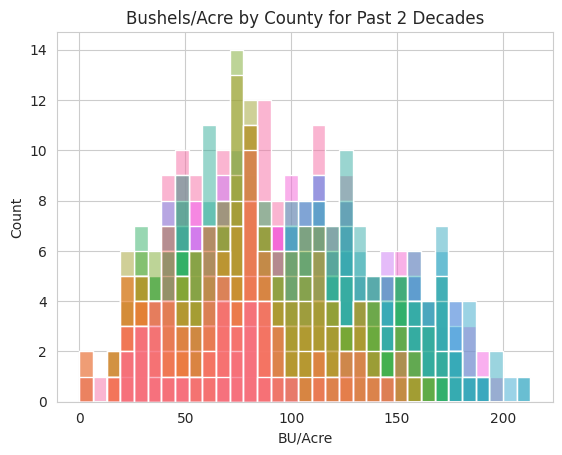

In [65]:
import matplotlib.pyplot as plt
sns.histplot(data=usda_subset, x="Value", hue="county_name", legend=False)
plt.xlabel('BU/Acre')
plt.title('Bushels/Acre by County for Past 2 Decades')
plt.show()

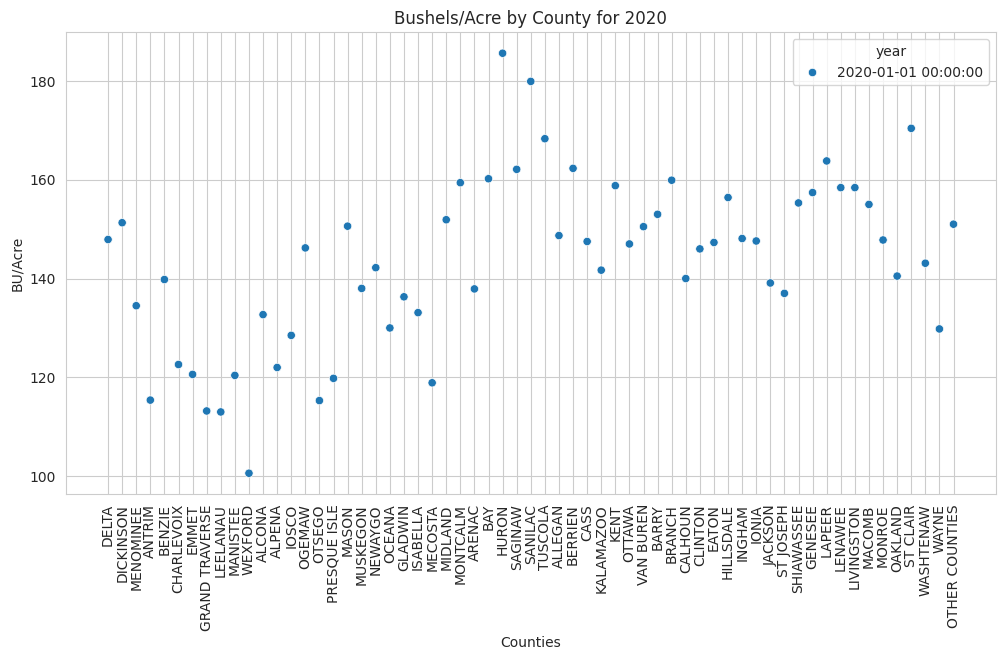

In [66]:
# Adjust figure size for better readability
plt.figure(figsize=(12, 6))

# Create the scatter plot
g = sns.scatterplot(data=usda_subset_2020, x="county_name", y="Value", hue="year")

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Counties')
plt.ylabel('BU/Acre')
plt.title('Bushels/Acre by County for 2020')

# Adjust the legend positioning
#g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

# Display the plot
plt.show()

It appears that perhaps the "Other Counties" was a dumping ground for smaller quanities collected over several counties. There is only one dot respresenting the one entry for the year 2020.

Was there really 3 entries for 1960 for "Other (Combined) Counties"? A dataset containing the 1960 entries will be created and investigated.

In [67]:
usda_subset_1960=usda_subset[usda_subset['year'] == '1960-01-01']

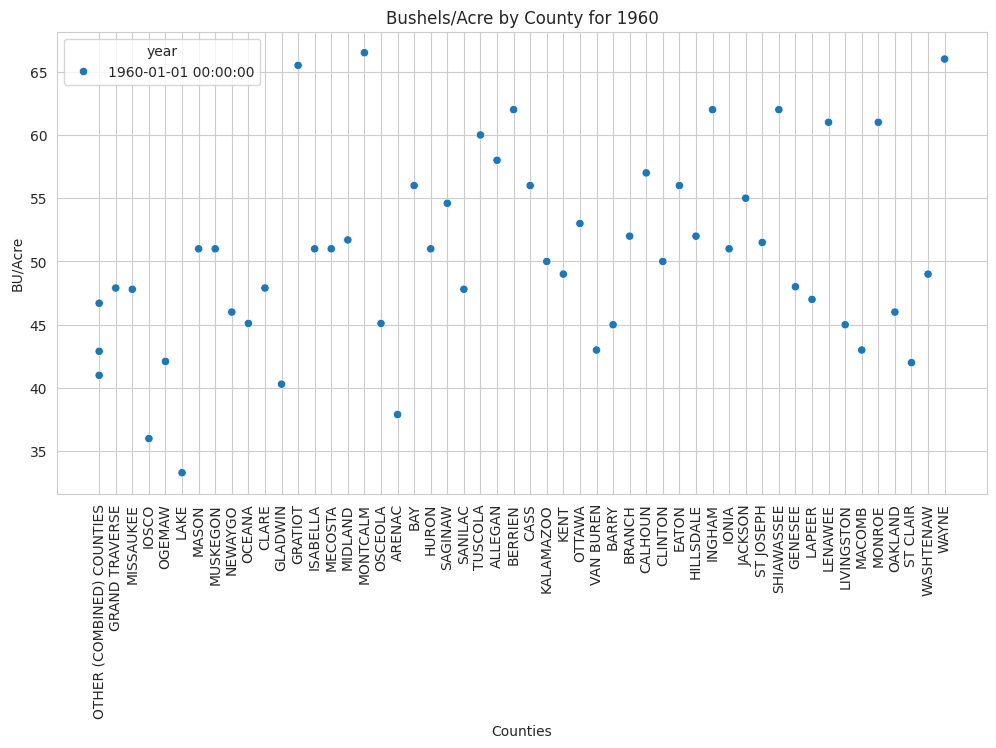

In [68]:
# Adjust figure size for better readability
plt.figure(figsize=(12, 6))

# Create the scatter plot
g = sns.scatterplot(data=usda_subset_1960, x="county_name", y="Value", hue="year")

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Counties')
plt.ylabel('BU/Acre')
plt.title('Bushels/Acre by County for 1960')

# Adjust the legend positioning
#g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

# Display the plot
plt.show()

Sure enough there are three dots over the "Other (Combined) Counties" mark. What does it look like when we look at the entered values?

In [69]:
usda_1960 = usda[(usda['year'] == '1960-01-01') & (usda['county_name'] == 'OTHER (COMBINED) COUNTIES')]
usda_1960

,class_desc,state_alpha,country_code,commodity_desc,country_name,short_desc,freq_desc,watershed_code,watershed_desc,year,...,asd_desc,source_desc,util_practice_desc,zip_5,state_ansi,domain_desc,county_code,location_desc,state_fips_code,state_name
0,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,1960-01-01,...,UPPER PENINSULA,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, UPPER PENINSULA, OTHER (COMBINED) CO...",26,MICHIGAN
1,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,1960-01-01,...,NORTHWEST,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, NORTHWEST, OTHER (COMBINED) COUNTIES",26,MICHIGAN
4,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,1960-01-01,...,NORTHEAST,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, NORTHEAST, OTHER (COMBINED) COUNTIES",26,MICHIGAN


The 3 entries for 1960 have the following asd_desc: "UPPER PENINSULA", "NORTHWEST", and "NORTHEAST". The location_desc has these entries: "MICHIGAN, UPPER PENINSULA, OTHER (COMBINED) COUNTIES", "MICHIGAN, NORTHWEST, OTHER (COMBINED) COUNTIES", and "MICHIGAN, NORTHEAST, OTHER (COMBINED) COUNTIES".

In [70]:
grouped_df = usda_subset_1960.groupby('county_name')['Value'].sum().reset_index()
print(grouped_df)

                  county_name  Value
0                     ALLEGAN   58.0
1                      ARENAC   37.9
2                       BARRY   45.0
3                         BAY   56.0
4                     BERRIEN   62.0
5                      BRANCH   52.0
6                     CALHOUN   57.0
7                        CASS   56.0
8                       CLARE   47.9
9                     CLINTON   50.0
10                      EATON   56.0
11                    GENESEE   48.0
12                    GLADWIN   40.3
13             GRAND TRAVERSE   47.9
14                    GRATIOT   65.5
15                  HILLSDALE   52.0
16                      HURON   51.0
17                     INGHAM   62.0
18                      IONIA   51.0
19                      IOSCO   36.0
20                   ISABELLA   51.0
21                    JACKSON   55.0
22                  KALAMAZOO   50.0
23                       KENT   49.0
24                       LAKE   33.3
25                     LAPEER   47.0
2

The total Value for 1960 "OTHER (COMBINED) COUNTIES" was 130.6
A similiar dumping ground value when compared to the single "OTHER COUNTIES" in 2020.

2019 seemed to have a lot of entries for "OTHER (COMBINED) COUNTIES". What is going on?

In [71]:
usda_2019 = usda[(usda['year'] == '2019-01-01') & (usda['county_name'] == 'OTHER (COMBINED) COUNTIES')]
usda_2019

,class_desc,state_alpha,country_code,commodity_desc,country_name,short_desc,freq_desc,watershed_code,watershed_desc,year,...,asd_desc,source_desc,util_practice_desc,zip_5,state_ansi,domain_desc,county_code,location_desc,state_fips_code,state_name
0,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,2019-01-01,...,UPPER PENINSULA,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, UPPER PENINSULA, OTHER (COMBINED) CO...",26,MICHIGAN
3,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,2019-01-01,...,NORTHWEST,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, NORTHWEST, OTHER (COMBINED) COUNTIES",26,MICHIGAN
10,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,2019-01-01,...,NORTHEAST,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, NORTHEAST, OTHER (COMBINED) COUNTIES",26,MICHIGAN
17,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,2019-01-01,...,WEST CENTRAL,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, WEST CENTRAL, OTHER (COMBINED) COUNTIES",26,MICHIGAN
21,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,2019-01-01,...,CENTRAL,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, CENTRAL, OTHER (COMBINED) COUNTIES",26,MICHIGAN
31,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,2019-01-01,...,SOUTHWEST,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, SOUTHWEST, OTHER (COMBINED) COUNTIES",26,MICHIGAN
36,ALL CLASSES,MI,9000,CORN,UNITED STATES,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",ANNUAL,0,NaN,2019-01-01,...,SOUTH CENTRAL,SURVEY,GRAIN,NaN,26,TOTAL,998,"MICHIGAN, SOUTH CENTRAL, OTHER (COMBINED) COUN...",26,MICHIGAN


The 7 entries for 2019 have the following asd_desc: "UPPER PENINSULA", "NORTHWEST", "NORTHEAST","WEST CENTRAL", "CENTRAL", "SOUTHWEST", and "SOUTH CENTRAL". The location_desc has these entries: "MICHIGAN, UPPER PENINSULA, OTHER (COMBINED) COUNTIES", "MICHIGAN, NORTHWEST, OTHER (COMBINED) COUNTIES", "MICHIGAN, NORTHEAST, OTHER (COMBINED) COUNTIES","MICHIGAN, WEST CENTRAL, OTHER (COMBINED) COUNTIES", "MICHIGAN, CENTRAL, OTHER (COMBINED) COUNTIES", "MICHIGAN, SOUTHWEST, OTHER (COMBINED) COUNTIES", and "MICHIGAN, SOUTH CENTRAL, OTHER (COMBINED) COUNTIES".

How many years and how many entries are we looking at that are like this? It looks like 2019 was the worst with 7 regions identified. The amount of bushels/acre is  886.3. This is considerably more than 1960.

In [72]:
grouped_df = usda.groupby(['year', 'county_name']).agg(
    count=('county_name', 'count'),
    sum=('Value', 'sum')
).reset_index()

filtered_df = grouped_df[grouped_df['count'] > 1]
# Sort by 'sum' in descending order
filtered_df = filtered_df.sort_values(by='sum', ascending=False)

print(filtered_df)

           year                county_name  count    sum
4768 2019-01-01  OTHER (COMBINED) COUNTIES      7  886.3
4610 2016-01-01  OTHER (COMBINED) COUNTIES      6  824.1
4551 2015-01-01  OTHER (COMBINED) COUNTIES      6  823.4
4670 2017-01-01  OTHER (COMBINED) COUNTIES      5  655.8
3942 2005-01-01  OTHER (COMBINED) COUNTIES      5  576.0
3638 2000-01-01  OTHER (COMBINED) COUNTIES      6  565.0
4001 2006-01-01  OTHER (COMBINED) COUNTIES      5  555.0
3589 1999-01-01  OTHER (COMBINED) COUNTIES      5  533.0
4061 2007-01-01  OTHER (COMBINED) COUNTIES      6  502.0
3881 2004-01-01  OTHER (COMBINED) COUNTIES      5  453.0
4120 2008-01-01  OTHER (COMBINED) COUNTIES      5  442.0
4493 2014-01-01  OTHER (COMBINED) COUNTIES      4  436.4
3820 2003-01-01  OTHER (COMBINED) COUNTIES      4  398.0
4717 2018-01-01  OTHER (COMBINED) COUNTIES      3  397.1
4248 2010-01-01  OTHER (COMBINED) COUNTIES      3  385.7
3464 1997-01-01  OTHER (COMBINED) COUNTIES      4  345.0
3691 2001-01-01  OTHER (COMBINE

             year                county_name  count    sum
4768 2019-01-01  OTHER (COMBINED) COUNTIES      7  886.3
4610 2016-01-01  OTHER (COMBINED) COUNTIES      6  824.1
4551 2015-01-01  OTHER (COMBINED) COUNTIES      6  823.4
4670 2017-01-01  OTHER (COMBINED) COUNTIES      5  655.8
3942 2005-01-01  OTHER (COMBINED) COUNTIES      5  576.0
3638 2000-01-01  OTHER (COMBINED) COUNTIES      6  565.0
4001 2006-01-01  OTHER (COMBINED) COUNTIES      5  555.0
3589 1999-01-01  OTHER (COMBINED) COUNTIES      5  533.0
4061 2007-01-01  OTHER (COMBINED) COUNTIES      6  502.0
3881 2004-01-01  OTHER (COMBINED) COUNTIES      5  453.0
4120 2008-01-01  OTHER (COMBINED) COUNTIES      5  442.0
4493 2014-01-01  OTHER (COMBINED) COUNTIES      4  436.4
3820 2003-01-01  OTHER (COMBINED) COUNTIES      4  398.0
4717 2018-01-01  OTHER (COMBINED) COUNTIES      3  397.1
4248 2010-01-01  OTHER (COMBINED) COUNTIES      3  385.7
3464 1997-01-01  OTHER (COMBINED) COUNTIES      4  345.0
3691 2001-01-01  OTHER (COMBINED) COUNTIES      6  327.0
3757 2002-01-01  OTHER (COMBINED) COUNTIES      3  308.0
4183 2009-01-01  OTHER (COMBINED) COUNTIES      3  303.0
4314 2011-01-01  OTHER (COMBINED) COUNTIES      3  288.7
4432 2013-01-01  OTHER (COMBINED) COUNTIES      2  245.4
4377 2012-01-01  OTHER (COMBINED) COUNTIES      3  239.2
3530 1998-01-01  OTHER (COMBINED) COUNTIES      3  230.0
3406 1996-01-01  OTHER (COMBINED) COUNTIES      3  206.0
3340 1995-01-01  OTHER (COMBINED) COUNTIES      2  180.0
1232 1967-01-01  OTHER (COMBINED) COUNTIES      3  172.8
2190 1980-01-01  OTHER (COMBINED) COUNTIES      2  160.6
1128 1965-01-01  OTHER (COMBINED) COUNTIES      3  159.3
1180 1966-01-01  OTHER (COMBINED) COUNTIES      3  152.5
2044 1978-01-01  OTHER (COMBINED) COUNTIES      2  150.0
2117 1979-01-01  OTHER (COMBINED) COUNTIES      2  147.4
952  1962-01-01  OTHER (COMBINED) COUNTIES      3  144.8
1004 1963-01-01  OTHER (COMBINED) COUNTIES      3  142.2
900  1961-01-01  OTHER (COMBINED) COUNTIES      3  139.2
848  1960-01-01  OTHER (COMBINED) COUNTIES      3  130.6

When comparing to the rest of the entries in 2019. How bad does it look?

In [73]:
usda_subset_2019=usda_subset[usda_subset['year'] == '2019-01-01']
grouped_df_2019 = usda_subset_2019.groupby(['year', 'county_name']).agg(
    count=('county_name', 'count'),
    sum=('Value', 'sum')
).reset_index()

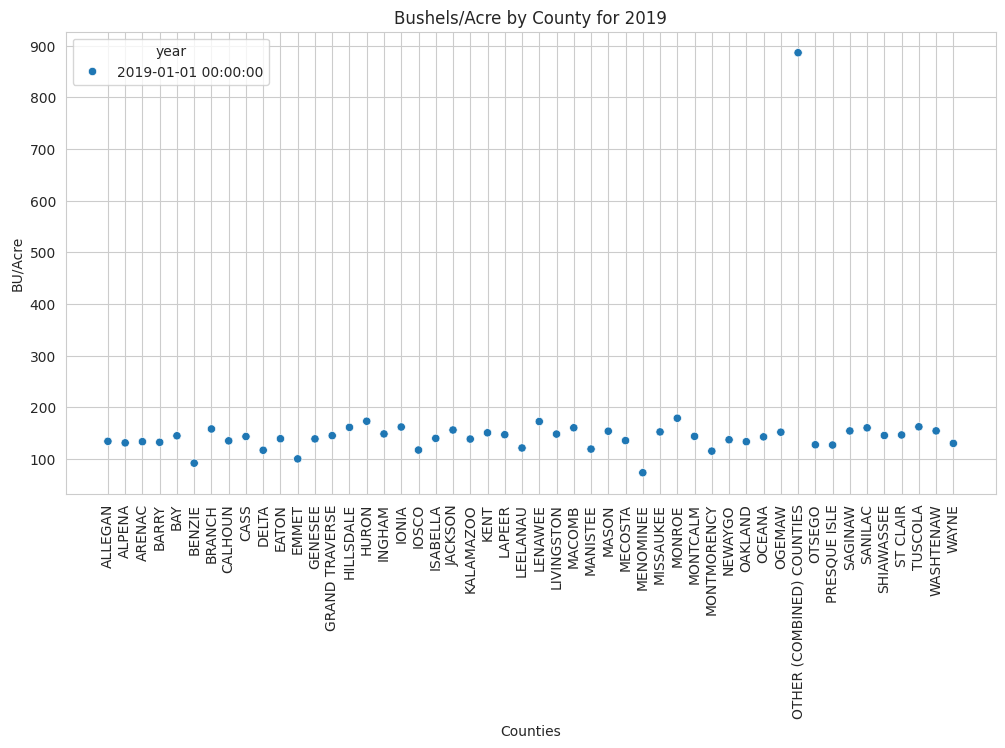

In [74]:
# Adjust figure size for better readability
plt.figure(figsize=(12, 6))

# Create the scatter plot
g = sns.scatterplot(data=grouped_df_2019, x="county_name", y="sum", hue="year")

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Counties')
plt.ylabel('BU/Acre')
plt.title('Bushels/Acre by County for 2019')

# Adjust the legend positioning
#g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

# Display the plot
plt.show()

The rest of the counties for 2019 produced no more than 200 bushels/acre. As expected, "OTHER (COMBINED) COUNTIES" is the highest in the chart.

In [75]:
# GDD calculation function
def calculate_gdd(df, base_temp=50, upper_temp=86):
    """
    Calculate Growing Degree Days (GDD) for corn.
    """
    df['TMAX'] = df['TMAX'].clip(lower=base_temp, upper=upper_temp)
    df['TMIN'] = df['TMIN'].clip(lower=base_temp)
    df['TAVG'] = (df['TMAX'] + df['TMIN']) / 2
    df['GDD'] = df['TAVG'] - base_temp
    return df

In [76]:
weather = calculate_gdd(weather)

In [77]:
# Compare average yield for usda_data_1955 and usda_data_2015
usda_1955 = pd.read_csv('data/usda_data_1955.csv')
usda_2015 = pd.read_csv('data/usda_data_2015.csv')

usda_1955['Value'].mean(), usda_2015['Value'].mean()

# whats the std deviation of yield for those years
usda_1955['Value'].std(), usda_2015['Value'].std()


(np.float64(13.073795653570846), np.float64(24.464792513092227))

In [78]:
# Compare total gdd for weather_data_1955 and weather_data_2015 for county_ansi=161
weather_2014 = pd.read_csv('data/weather_data_2014.csv')
weather_2023 = pd.read_csv('data/weather_data_2023.csv')

weather_2014 = calculate_gdd(weather_2014)
weather_2023 = calculate_gdd(weather_2023)

weather_2014[weather_2014['county_ansi'] == 161]['GDD'].sum(), weather_2023[weather_2023['county_ansi'] == 161]['GDD'].sum()

# Do this for all years between 1950 and 1959
gdd = []
for year in range(1950, 1960):
    weather = pd.read_csv(f'data/weather_data_{year}.csv')
    weather = calculate_gdd(weather)
    gdd.append(weather[weather['county_ansi'] == 161]['GDD'].sum())

gdd


[np.float64(2327.0),
 np.float64(2495.5),
 np.float64(2726.5),
 np.float64(2707.0),
 np.float64(2592.5),
 np.float64(1383.0),
 np.float64(2510.5),
 np.float64(2611.5),
 np.float64(2563.0),
 np.float64(2879.0)]

In [79]:
# Combine all weather data into a single DataFrame
weather_data = pd.concat([pd.read_csv(f'data/weather_data_{year}.csv') for year in range(1950, 2024)])
# Calculate GDD for each day
weather_data = calculate_gdd(weather_data)
weather_data


,date,TMAX,TMIN,PRCP,state_ansi,county_ansi,TAVG,GDD
0,1950-05-15,50.333333,50.000000,0.000000,26,3.0,50.166667,0.166667
1,1950-05-16,50.000000,50.000000,0.000000,26,3.0,50.000000,0.000000
2,1950-05-17,54.333333,50.000000,0.000000,26,3.0,52.166667,2.166667
3,1950-05-18,58.333333,50.000000,0.000000,26,3.0,54.166667,4.166667
4,1950-05-19,72.666667,50.000000,0.000000,26,3.0,61.333333,11.333333
...,...,...,...,...,...,...,...,...
8752,2023-07-17,NaN,NaN,0.148785,26,NaN,NaN,NaN
8753,2023-08-16,76.476744,53.632184,0.093815,26,NaN,65.054464,15.054464
8754,2023-08-17,NaN,NaN,0.161421,26,NaN,NaN,NaN
8755,2023-09-16,71.023392,50.000000,0.021863,26,NaN,60.511696,10.511696


In [80]:
# Convert 'date' to datetime if it's not already
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Extract year and month
weather_data['year'] = weather_data['date'].dt.year
weather_data['month'] = weather_data['date'].dt.month

# Aggregate GDD by county and year
gdd_annual = weather_data.groupby(['state_ansi', 'county_ansi', 'year'])['GDD'].sum().reset_index()
gdd_annual


,state_ansi,county_ansi,year,GDD
0,26,1.0,1950,1837.50
1,26,1.0,1951,1840.50
2,26,1.0,1952,2111.50
3,26,1.0,1953,2044.00
4,26,1.0,1954,1967.50
...,...,...,...,...
4813,26,165.0,2015,2149.50
4814,26,165.0,2016,2419.00
4815,26,165.0,2020,2273.75
4816,26,165.0,2021,2396.00


In [81]:
# Combine all USDA data into a single DataFrame usda_data
usda_data = pd.concat([pd.read_csv(f'data/usda_data_{year}.csv') for year in range(1950, 2024)])

In [82]:
# I added some lines to clean the data, most files are fine but I am looking for the 'YIELD' data and skipping any suppressed data

# Filter for the relevant data (e.g., 'YIELD' in 'statisticcat_desc')
corn_data = usda_data[usda_data['statisticcat_desc'] == 'YIELD']

# Convert 'Value' to numeric, removing any commas or missing values
corn_data['Value'] = corn_data['Value'].replace(',', '', regex=True)
corn_data = corn_data[corn_data['Value'] != '(D)']  # Remove suppressed data
corn_data['Value'] = pd.to_numeric(corn_data['Value'])

# Select relevant columns
corn_data = corn_data[['state_ansi', 'county_ansi', 'year', 'Value']]


In [83]:
# Merge the GDD and corn yield data to make a single DataFrame

# Merge on 'state_ansi', 'county_ansi', and 'year'
merged_data = pd.merge(gdd_annual, corn_data, on=['state_ansi', 'county_ansi', 'year'])
# Remove entries with zero or NaN yields
merged_data = merged_data[merged_data['Value'] > 0]
# Remove entries with zero or NaN yields
merged_data = merged_data[merged_data['GDD'] > 0]



In [84]:
# Dump merged_data to csv to test
merged_data.to_csv('merged_data.csv', index=False)

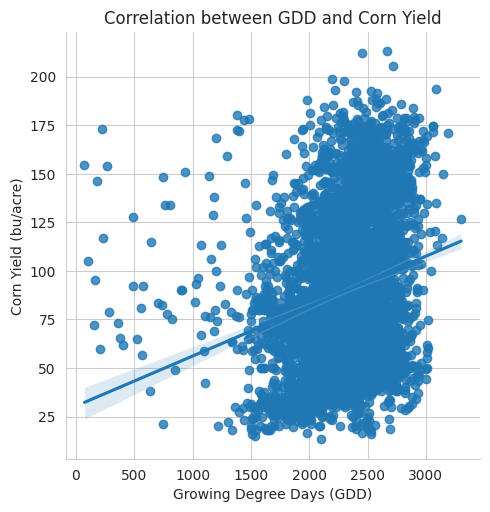

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of GDD vs. corn yield
sns.lmplot(x='GDD', y='Value', data=merged_data)
plt.title('Correlation between GDD and Corn Yield')
plt.xlabel('Growing Degree Days (GDD)')
plt.ylabel('Corn Yield (bu/acre)')
plt.show()


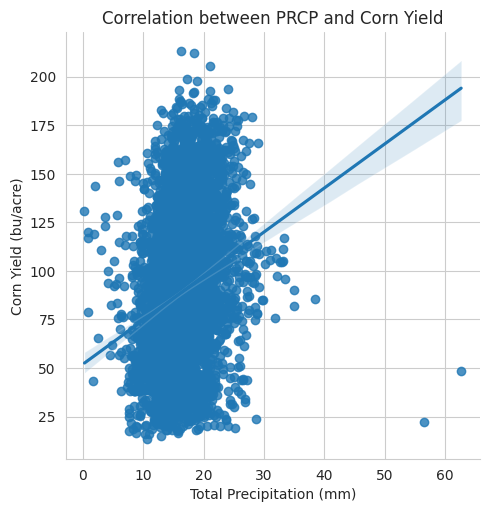

In [86]:
# Make the same chart with PRCP instead of GDD

# Calculate total precipitation for the growing season
weather_data['PRCP'] = weather_data['PRCP'].clip(lower=0)
prcp_annual = weather_data.groupby(['state_ansi', 'county_ansi', 'year'])['PRCP'].sum().reset_index()

# Merge on 'state_ansi', 'county_ansi', and 'year'
merged_data_prcp = pd.merge(prcp_annual, corn_data, on=['state_ansi', 'county_ansi', 'year'])
# Remove entries with zero or NaN yields
merged_data_prcp = merged_data_prcp[merged_data_prcp['Value'] > 0]
# Remove entries with zero or NaN yields
merged_data_prcp = merged_data_prcp[merged_data_prcp['PRCP'] > 0]

# Scatter plot with regression line
sns.lmplot(x='PRCP', y='Value', data=merged_data_prcp)
plt.title('Correlation between PRCP and Corn Yield')
plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Corn Yield (bu/acre)')
plt.show()


In [87]:
# Add precipitation data to the merged dataframe
prcp_annual = weather_data.groupby(['state_ansi', 'county_ansi', 'year'])['PRCP'].sum().reset_index()
merged_data = pd.merge(merged_data, prcp_annual, on=['state_ansi', 'county_ansi', 'year'])


In [88]:
import statsmodels.api as sm

# Define independent variables and dependent variable
X = merged_data[['GDD', 'PRCP']]
y = merged_data['Value']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     270.7
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          5.75e-112
Time:                        23:19:02   Log-Likelihood:                -23489.
No. Observations:                4676   AIC:                         4.698e+04
Df Residuals:                    4673   BIC:                         4.700e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2874      3.976      0.072      0.9

I used chatGPT to add some centext to the OLS model.

Let's break down the key components of your OLS (Ordinary Least Squares) regression results:

### 1. **Model Overview:**
   - **Dep. Variable (Dependent Variable):** This is the variable you're trying to predict, in this case, labeled as "Value."
   - **Model:** OLS, meaning this is a simple linear regression model using the least squares method.
   - **No. Observations:** 4673 observations (data points) were used in this regression.

### 2. **R-squared:**
   - **R-squared (0.099):** This indicates that the model explains about **9.9% of the variance** in the dependent variable ("Value"). This is a relatively low R-squared value, meaning that most of the variability in the data is not explained by the model.
   - **Adj. R-squared (0.098):** This is a slightly adjusted version of R-squared that accounts for the number of predictors in the model. It's still low, meaning the model is not very strong at explaining the data.

### 3. **F-statistic and p-value (Prob F-statistic):**
   - **F-statistic (255.8):** This tests the overall significance of the model. A higher F-statistic generally means the model is a good fit.
   - **Prob(F-statistic) (3.88e-106):** The p-value associated with the F-statistic is incredibly small (close to zero), meaning the model is statistically significant overall. So, even though the model doesn't explain much variance (low R-squared), it's still better than having no model at all.

### 4. **Coefficients (coef), t-values, and p-values:**
   These are the estimated effects of each independent variable on the dependent variable.
   - **const (Intercept) (0.0849):** This is the value of the dependent variable ("Value") when all independent variables (GDD, PRCP) are zero. The p-value for this is 0.983, which means it's not statistically significant.
   - **GDD (0.0274):** This means that for each unit increase in GDD (an independent variable), the dependent variable increases by approximately 0.0274 units. The p-value is 0.000, so this is a statistically significant effect.
   - **PRCP (1.9657):** This means that for each unit increase in PRCP, the dependent variable increases by 1.9657 units. The p-value is also 0.000, indicating a highly significant effect.

### 5. **Standard Error (std err):**
   - The standard errors give a measure of the variability in the coefficient estimates. For example, the standard error for GDD is 0.002, which indicates a small amount of variability, suggesting a reliable estimate.

### 6. **t-value and p-value:**
   - **t-value:** This tells you how many standard errors the coefficient is away from zero. Higher absolute t-values indicate that the corresponding coefficient is statistically significant.
   - **p-value:** This tells you whether the coefficient is statistically significant. For GDD and PRCP, the p-values are 0.000, meaning both are statistically significant. The intercept is not significant (p-value = 0.983).

### 7. **Durbin-Watson (0.422):**
   - This statistic tests for autocorrelation in the residuals (errors). A value close to 2 means there is no autocorrelation. Here, 0.422 is quite low, suggesting the possibility of positive autocorrelation, which might need further investigation.

### 8. **Omnibus and Jarque-Bera (JB) tests:**
   - These are tests for normality of the residuals. The p-values for these tests are very small (Prob(Omnibus) = 0.000, Prob(JB) = 8.09e-35), indicating that the residuals are not normally distributed, which could be a problem depending on the assumptions of your model.

### 9. **Condition Number (1.66e+04):**
   - A high condition number suggests multicollinearity, meaning that the independent variables are highly correlated. The condition number here (16,600) is quite high, indicating potential multicollinearity issues.

### Conclusion:
- The model is statistically significant, but it doesn't explain much of the variability in the dependent variable (low R-squared).
- The variables **GDD** and **PRCP** have a significant impact on the dependent variable ("Value").
- However, there may be issues with autocorrelation (Durbin-Watson) and multicollinearity (high condition number), and the residuals don't appear to be normally distributed (Omnibus and JB tests). You might need to address these issues if you want to improve the model.

In [89]:
# Cleaning up 'Value' to make sure we have something to work with
usda_data['Value'] = usda_data['Value'].replace(',', '', regex=True)
usda_data['Value'] = usda_data['Value'].replace({'(D)': np.nan, '(Z)': np.nan, '(NA)': np.nan, '': np.nan})
usda_data['Value'] = pd.to_numeric(usda_data['Value'], errors='coerce')

# Filter for the relevant data (e.g., 'YIELD' in 'statisticcat_desc')
corn_data = usda_data[usda_data['statisticcat_desc'] == 'YIELD']

# Select relevant columns, including 'county_name'
corn_data = corn_data[['state_ansi', 'county_ansi', 'year', 'Value', 'county_name']]

# Drop rows with missing values in 'Value' or 'county_name'
corn_data.dropna(subset=['Value', 'county_name'], inplace=True)

# Ensure 'year' is integer
corn_data['year'] = corn_data['year'].astype(int)


In [90]:
# Merge on 'state_ansi', 'county_ansi', and 'year'
merged_data = pd.merge(gdd_annual, corn_data, on=['state_ansi', 'county_ansi', 'year'])

# Drop any rows with missing values
merged_data.dropna(subset=['GDD', 'Value'], inplace=True)


In [91]:
# Calculate average yield per county
avg_yield_per_county = merged_data.groupby(['county_ansi', 'county_name'])['Value'].mean().reset_index()

# Sort and select top 5 counties
top_counties = avg_yield_per_county.sort_values(by='Value', ascending=False).head(5)

# Filter data for these counties
top_county_codes = top_counties['county_ansi'].unique()
top_county_names = top_counties['county_name'].unique()
top_counties_data = merged_data[merged_data['county_ansi'].isin(top_county_codes)]


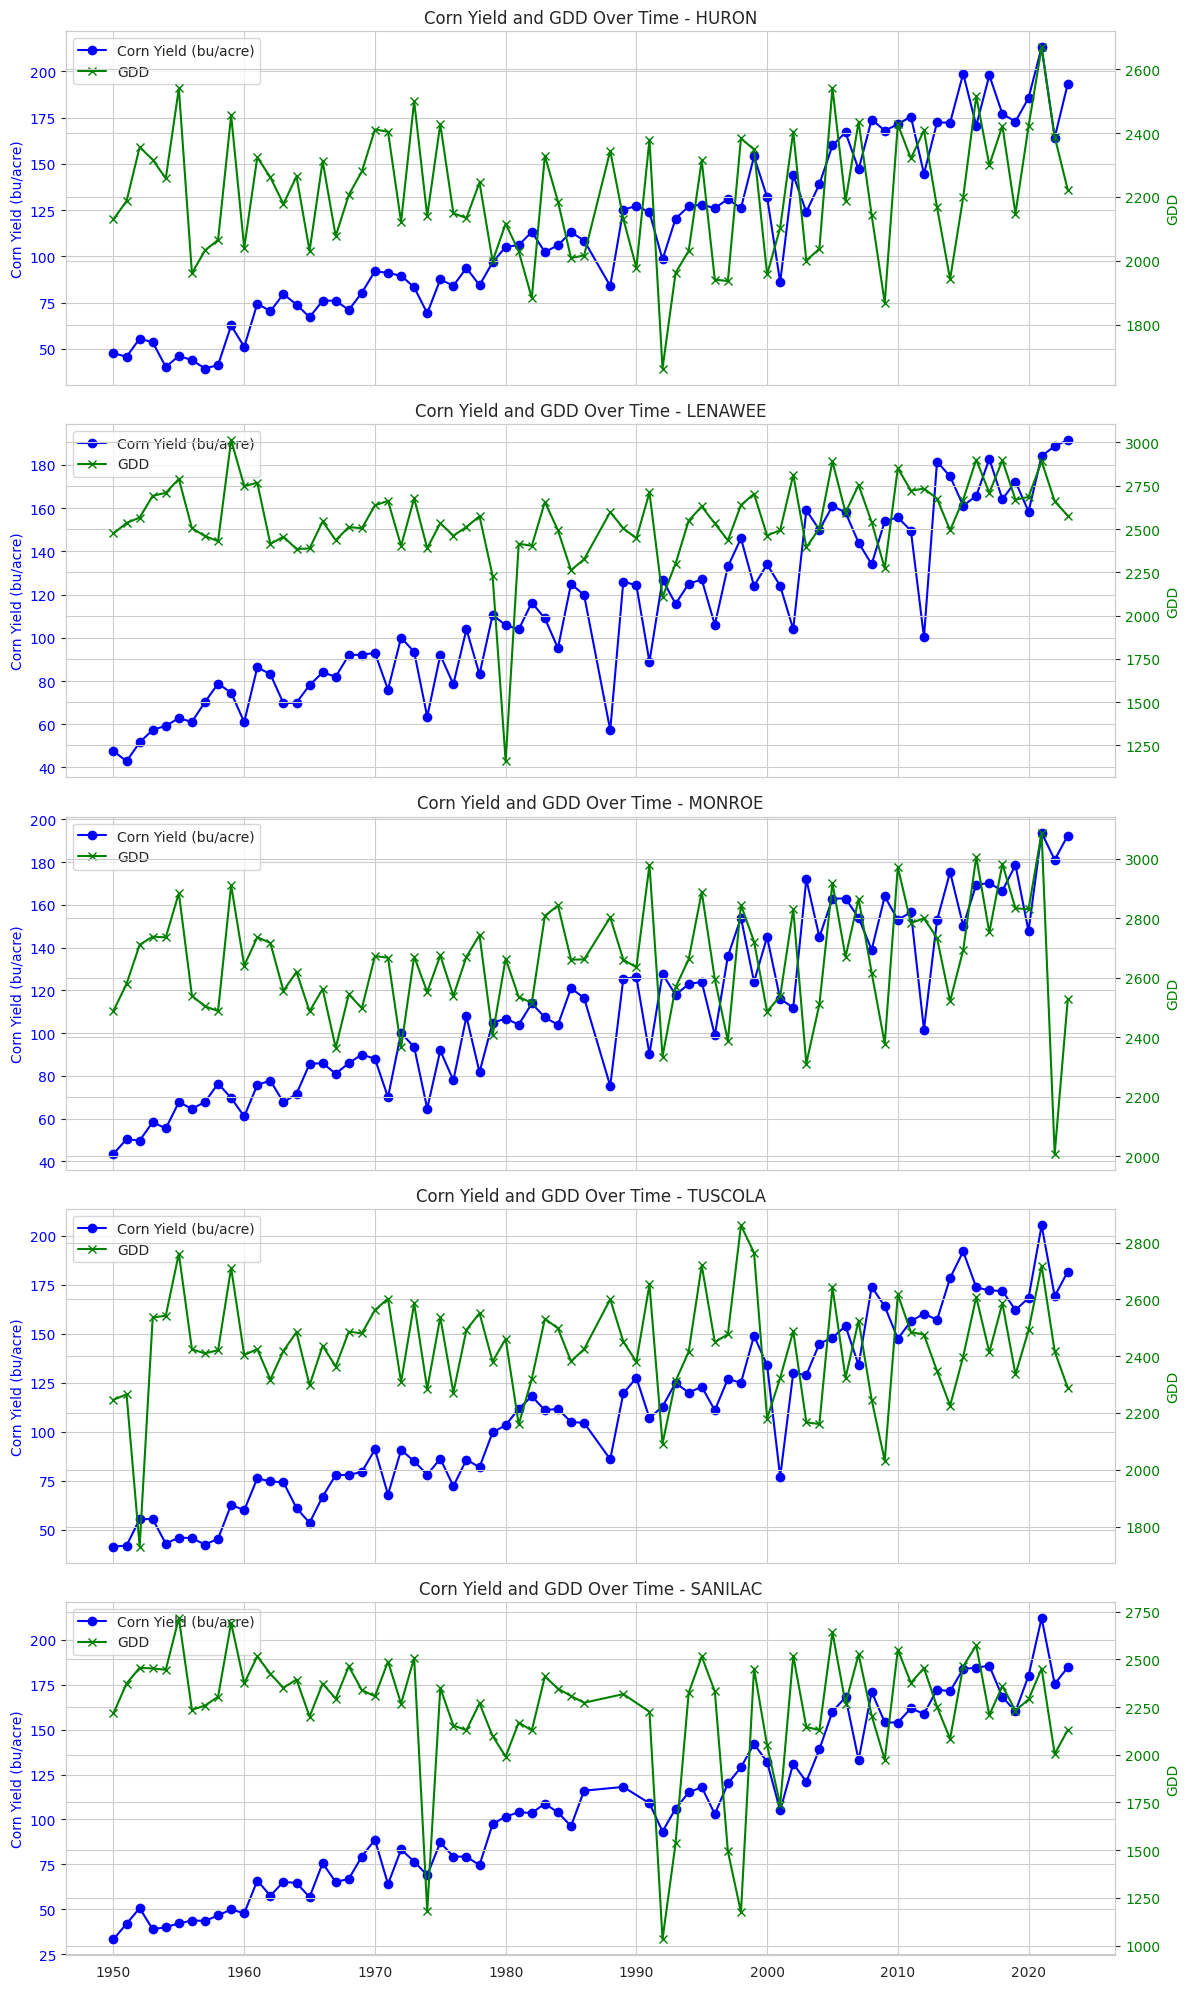

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# We can use a different plotting lib I just wnated something quick

sns.set_style('whitegrid')
num_counties = len(top_county_codes)
fig, axes = plt.subplots(nrows=num_counties, ncols=1, figsize=(12, num_counties * 4), sharex=True)

# Ensure axes is iterable
if num_counties == 1:
    axes = [axes]

for ax, county_code, county_name in zip(axes, top_county_codes, top_county_names):
    county_data = top_counties_data[top_counties_data['county_ansi'] == county_code]
    county_data = county_data.sort_values('year')

    # Plot Yield
    ax.plot(county_data['year'], county_data['Value'], color='blue', marker='o', label='Corn Yield (bu/acre)')
    ax.set_ylabel('Corn Yield (bu/acre)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for GDD
    ax2 = ax.twinx()
    ax2.plot(county_data['year'], county_data['GDD'], color='green', marker='x', label='GDD')
    ax2.set_ylabel('GDD', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Title with county name
    ax.set_title(f'Corn Yield and GDD Over Time - {county_name}')

    # Add legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper left')

# Set common x-label
plt.xlabel('Year')
plt.tight_layout()
plt.show()


In [93]:
# Calculate the average yield per county over the entire period
average_yield = merged_data.groupby('county_name')['Value'].mean().reset_index()

# Sort counties by average yield in descending order
average_yield_sorted = average_yield.sort_values(by='Value', ascending=False)

# Top 10 counties
print("Top 10 Counties by Average Corn Yield:")
print(average_yield_sorted.head(10))


Top 10 Counties by Average Corn Yield:
   county_name       Value
31       HURON  112.912329
45     LENAWEE  112.695890
57      MONROE  112.680822
78     TUSCOLA  109.668493
73     SANILAC  107.457746
72     SAGINAW  107.410959
8          BAY  107.359722
28     GRATIOT  106.084507
33       IONIA  105.286111
32      INGHAM  103.489041


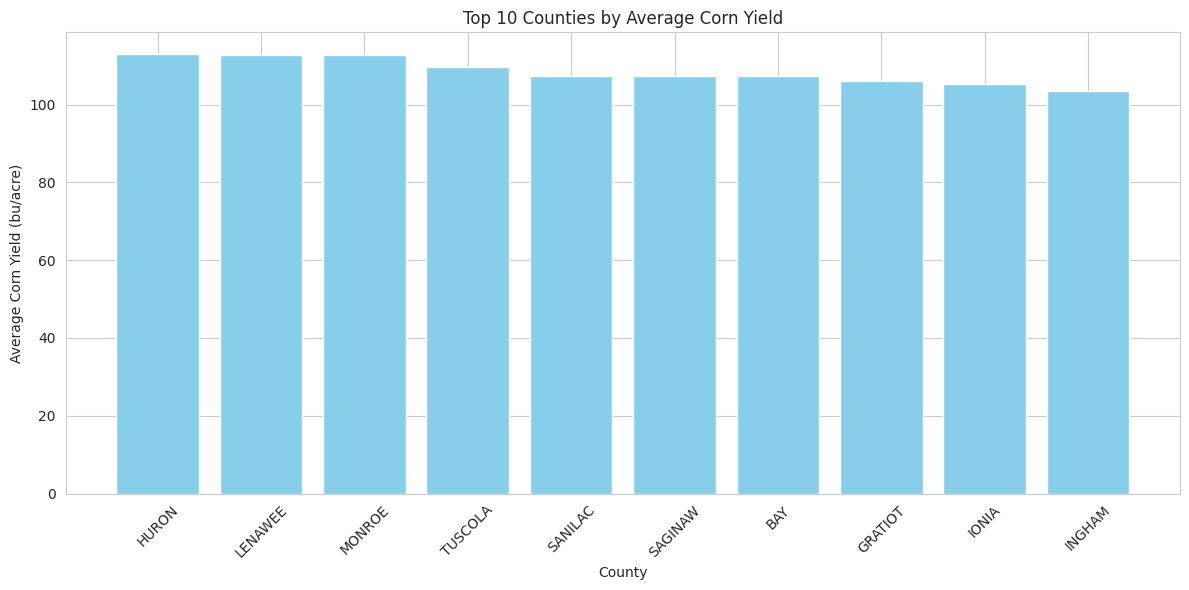

In [94]:
# Bar plot of average yields for top 10 counties
plt.figure(figsize=(12, 6))
plt.bar(average_yield_sorted['county_name'].head(10), average_yield_sorted['Value'].head(10), color='skyblue')
plt.xticks(rotation=45)
plt.xlabel('County')
plt.ylabel('Average Corn Yield (bu/acre)')
plt.title('Top 10 Counties by Average Corn Yield')
plt.tight_layout()
plt.show()


In [95]:
# I was wondering if we pick the best based how consistent are they in beating the state average

# Calculate the state average yield for each year
state_average_yield = merged_data.groupby('year')['Value'].mean().reset_index(name='state_avg_yield')

# Merge state average back into merged_data
merged_data_with_state_avg = pd.merge(merged_data, state_average_yield, on='year')

# Create a flag for whether the county's yield is above the state average each year
merged_data_with_state_avg['above_state_avg'] = merged_data_with_state_avg['Value'] > merged_data_with_state_avg['state_avg_yield']

# Calculate the percentage of years each county was above the state average
county_performance = merged_data_with_state_avg.groupby('county_name')['above_state_avg'].mean().reset_index()

# Convert to percentage
county_performance['percent_above_state_avg'] = county_performance['above_state_avg'] * 100

# Sort counties by percentage in descending order
county_performance_sorted = county_performance.sort_values(by='percent_above_state_avg', ascending=False)

# Display the top 10 counties
print("Top 10 Counties by Consistency in Exceeding State Average Yield:")
print(county_performance_sorted.head(10))


Top 10 Counties by Consistency in Exceeding State Average Yield:
   county_name  above_state_avg  percent_above_state_avg
72     SAGINAW         0.986301                98.630137
78     TUSCOLA         0.972603                97.260274
8          BAY         0.972222                97.222222
28     GRATIOT         0.971831                97.183099
57      MONROE         0.958904                95.890411
31       HURON         0.945205                94.520548
45     LENAWEE         0.931507                93.150685
33       IONIA         0.916667                91.666667
22       EATON         0.902778                90.277778
73     SANILAC         0.901408                90.140845


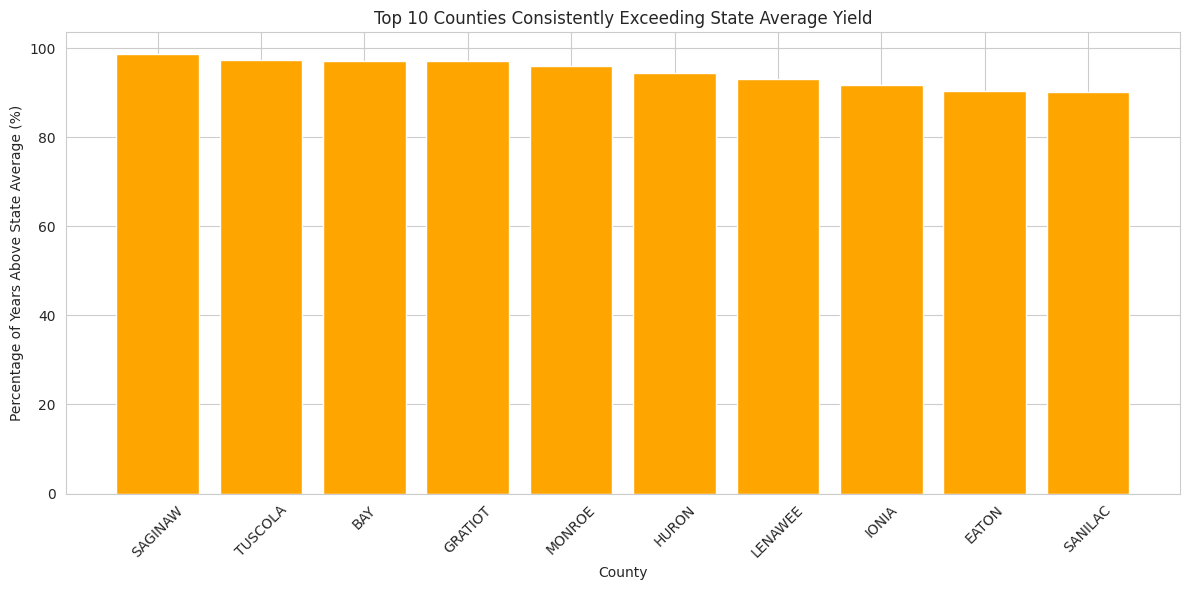

In [96]:
# Bar plot of top 10 counties by percentage of years above state average
plt.figure(figsize=(12, 6))
plt.bar(county_performance_sorted['county_name'].head(10), county_performance_sorted['percent_above_state_avg'].head(10), color='orange')
plt.xticks(rotation=45)
plt.xlabel('County')
plt.ylabel('Percentage of Years Above State Average (%)')
plt.title('Top 10 Counties Consistently Exceeding State Average Yield')
plt.tight_layout()
plt.show()


In [97]:
# What about finding the best improved county over time wiht slope

# Pulling this in for linregress regression
from scipy.stats import linregress

# Prepare a DataFrame to store slopes
county_slopes = []

for county in merged_data['county_name'].unique():
    county_data = merged_data[merged_data['county_name'] == county]
    if len(county_data['year'].unique()) > 1:  # Ensure there's enough data
        slope, intercept, r_value, p_value, std_err = linregress(county_data['year'], county_data['Value'])
        county_slopes.append({'county_name': county, 'slope': slope, 'p_value': p_value})
    else:
        county_slopes.append({'county_name': county, 'slope': np.nan, 'p_value': np.nan})

# Convert to DataFrame
slopes_df = pd.DataFrame(county_slopes)

# Remove counties with NaN slopes
slopes_df.dropna(subset=['slope'], inplace=True)

# Sort counties by slope
slopes_df_sorted = slopes_df.sort_values(by='slope', ascending=False)

print("Top 10 Counties by Yield Improvement Over Time:")
print(slopes_df_sorted.head(10))


Top 10 Counties by Yield Improvement Over Time:
   county_name     slope       p_value
75     SANILAC  2.075473  3.088165e-44
31       HURON  2.044288  3.885793e-40
78     TUSCOLA  1.924358  9.986050e-40
55     MIDLAND  1.920669  1.193659e-43
33       IONIA  1.889841  8.581221e-42
30    HOUGHTON  1.887637  1.787827e-11
2      ALLEGAN  1.836926  1.833743e-34
8          BAY  1.836875  1.518069e-39
79   VAN BUREN  1.826640  1.905847e-27
10     BERRIEN  1.821258  1.095833e-35


In [98]:
# Lets looks at the counties that have been the most consistent in their yield over time

# Calculate standard deviation of yield per county
yield_variability = merged_data.groupby('county_name')['Value'].std().reset_index(name='yield_std')

# Sort counties by yield_std in ascending order
yield_variability_sorted = yield_variability.sort_values(by='yield_std')

print("Top 10 Counties with Least Yield Variability:")
print(yield_variability_sorted.head(10))


Top 10 Counties with Least Yield Variability:
   county_name  yield_std
41    KEWEENAW  11.300442
19    CRAWFORD  18.434486
35        IRON  20.029078
6       BARAGA  22.364734
67      OSCODA  22.709543
16    CHIPPEWA  23.270856
26     GOGEBIC  24.020784
71   ROSCOMMON  24.942235
44    LEELANAU  25.030509
47        LUCE  25.246292


In [99]:
# Use county_name to merge all the other DFs
county_metrics = average_yield[['county_name', 'Value']].merge(
    county_performance[['county_name', 'percent_above_state_avg']], on='county_name').merge(
    slopes_df[['county_name', 'slope']], on='county_name').merge(
    yield_variability[['county_name', 'yield_std']], on='county_name')

# Normalize the metrics
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

county_metrics[['avg_yield_norm', 'percent_above_avg_norm', 'slope_norm', 'yield_std_norm']] = scaler.fit_transform(
    county_metrics[['Value', 'percent_above_state_avg', 'slope', 'yield_std']])

# Invert yield_std_norm so that lower variability scores higher
county_metrics['yield_std_norm'] = 1 - county_metrics['yield_std_norm']

# I assigned weights to each metric but nothing scientific
# Should come back to this later
county_metrics['total_score'] = (
    county_metrics['avg_yield_norm'] * 0.4 +
    county_metrics['percent_above_avg_norm'] * 0.3 +
    county_metrics['slope_norm'] * 0.2 +
    county_metrics['yield_std_norm'] * 0.1
)

# Sort counties by total_score
county_metrics_sorted = county_metrics.sort_values(by='total_score', ascending=False)

print("Top 10 Counties by Composite Score:")
print(county_metrics_sorted[['county_name', 'total_score']].head(10))


Top 10 Counties by Composite Score:
   county_name  total_score
57      MONROE     0.902075
45     LENAWEE     0.893660
31       HURON     0.888859
78     TUSCOLA     0.883416
72     SAGINAW     0.881322
8          BAY     0.874440
28     GRATIOT     0.872573
73     SANILAC     0.843182
33       IONIA     0.842992
22       EATON     0.830837


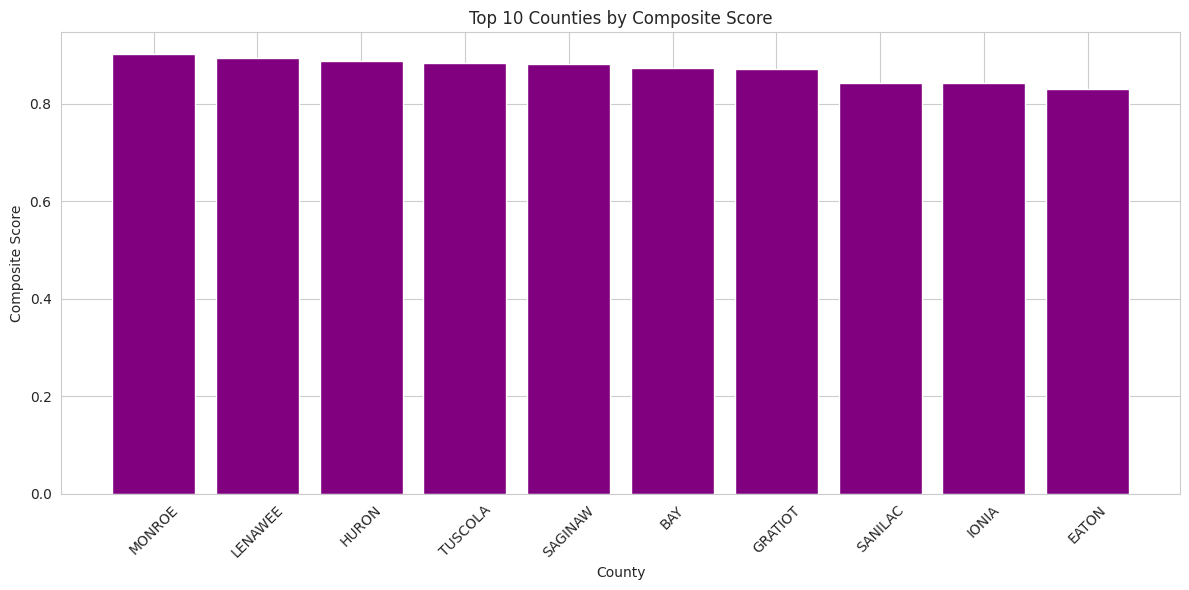

In [100]:
# Bar plot of top 10 counties by composite score
plt.figure(figsize=(12, 6))
plt.bar(county_metrics_sorted['county_name'].head(10), county_metrics_sorted['total_score'].head(10), color='purple')
plt.xticks(rotation=45)
plt.xlabel('County')
plt.ylabel('Composite Score')
plt.title('Top 10 Counties by Composite Score')
plt.tight_layout()
plt.show()


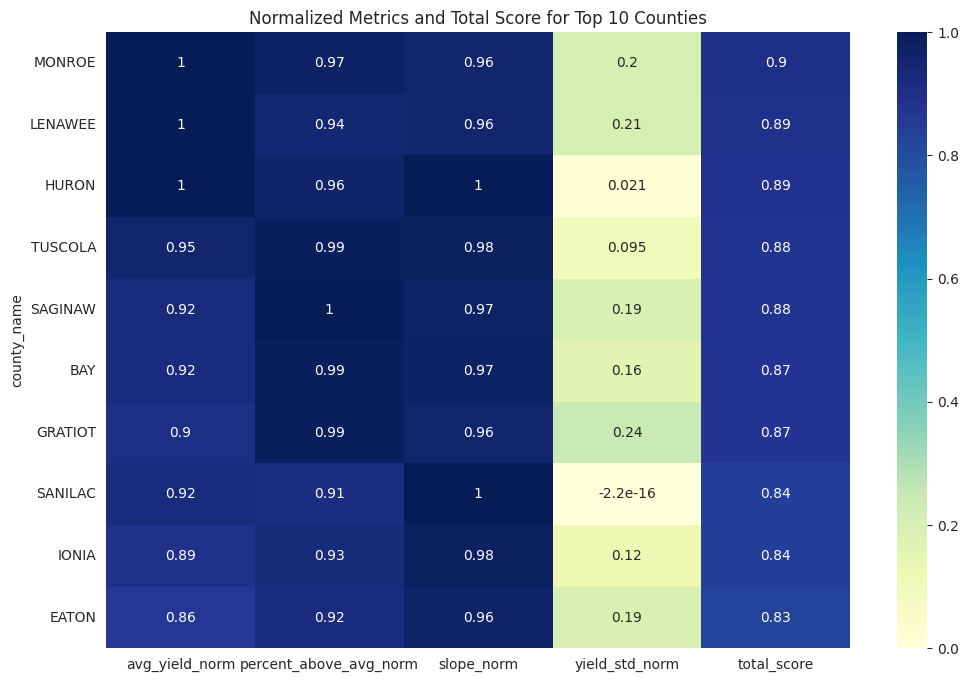

In [101]:
import seaborn as sns

# Prepare data for heatmap
metrics_for_heatmap = county_metrics_sorted[['county_name', 'avg_yield_norm', 'percent_above_avg_norm', 'slope_norm', 'yield_std_norm', 'total_score']].set_index('county_name')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_for_heatmap.head(10), annot=True, cmap='YlGnBu')
plt.title('Normalized Metrics and Total Score for Top 10 Counties')
plt.show()


In [103]:
# !pip install geopandas

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

counties_gdf = gpd.read_file('geojson/counties.geojson')

# # Filter for Michigan counties (State FIPS code for Michigan is '26')
counties_gdf = counties_gdf[counties_gdf['STATEFP'] == '26']


In [104]:
# Prepare your merged_data DataFrame
merged_data['state_ansi'] = merged_data['state_ansi'].astype(str).str.zfill(2)
merged_data['county_ansi'] = merged_data['county_ansi'].astype(str).str.zfill(3)
merged_data['county_fips'] = merged_data['state_ansi'] + merged_data['county_ansi']
merged_data



,state_ansi,county_ansi,year,GDD,Value,county_name,county_fips
0,26,1.0,1950,1837.50,30.3,ALCONA,261.0
1,26,1.0,1951,1840.50,29.0,ALCONA,261.0
2,26,1.0,1952,2111.50,39.9,ALCONA,261.0
3,26,1.0,1953,2044.00,34.0,ALCONA,261.0
4,26,1.0,1954,1967.50,25.5,ALCONA,261.0
...,...,...,...,...,...,...,...
4813,26,165.0,2015,2149.50,132.2,WEXFORD,26165.0
4814,26,165.0,2016,2419.00,96.5,WEXFORD,26165.0
4815,26,165.0,2020,2273.75,100.6,WEXFORD,26165.0
4816,26,165.0,2021,2396.00,136.4,WEXFORD,26165.0


In [105]:
# Calculate average yield per county
average_yield = merged_data.groupby('county_fips')['Value'].mean().reset_index(name='avg_yield')
# Print the data type for each column
print(average_yield.dtypes)
average_yield


county_fips     object
avg_yield      float64
dtype: object


,county_fips,avg_yield
0,261.0,68.500000
1,26101.0,72.165517
2,26103.0,51.600000
3,26105.0,84.182609
4,26107.0,85.665753
...,...,...
78,2691.0,112.695890
79,2693.0,95.826027
80,2695.0,50.450000
81,2697.0,55.403846


In [106]:
# Ensure the county FIPS codes in the geographic data match your data
# In the shapefile, county FIPS codes might be in 'GEOID' or similar
counties_gdf['county_fips'] = counties_gdf['STATEFP'] + counties_gdf['COUNTYFP']
print(counties_gdf.dtypes)
counties_gdf

STATEFP          object
COUNTYFP         object
COUNTYNS         object
AFFGEOID         object
GEOID            object
NAME             object
LSAD             object
ALAND             int64
AWATER            int64
geometry       geometry
county_fips      object
dtype: object


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,county_fips
55,26,107,01622996,0500000US26107,26107,Mecosta,06,1437745751,41762966,"POLYGON ((-85.56243 43.81548, -85.08881 43.813...",26107
70,26,077,01622981,0500000US26077,26077,Kalamazoo,06,1456083085,46882315,"POLYGON ((-85.7647 42.42071, -85.54319 42.4214...",26077
71,26,123,01623004,0500000US26123,26123,Newaygo,06,2112606166,119183856,"POLYGON ((-86.03949 43.46745, -86.03788 43.815...",26123
90,26,101,01622993,0500000US26101,26101,Manistee,06,1404616462,1912440724,"POLYGON ((-86.35164 44.22943, -86.26871 44.345...",26101
98,26,065,01622975,0500000US26065,26065,Ingham,06,1440322252,11920176,"POLYGON ((-84.60276 42.76988, -84.38471 42.769...",26065
...,...,...,...,...,...,...,...,...,...,...,...
2971,26,159,01623020,0500000US26159,26159,Van Buren,06,1574166310,1248671230,"POLYGON ((-86.35622 42.25417, -86.28445 42.394...",26159
3058,26,045,01622965,0500000US26045,26045,Eaton,06,1489714027,11011332,"POLYGON ((-85.07424 42.77078, -84.83708 42.770...",26045
3121,26,093,01622989,0500000US26093,26093,Livingston,06,1463693558,52500785,"POLYGON ((-84.15819 42.77664, -83.92252 42.780...",26093
3131,26,125,01623005,0500000US26125,26125,Oakland,06,2246869568,102863438,"POLYGON ((-83.68938 42.87126, -83.45336 42.880...",26125


In [107]:
# Cast the datatypes of county_fips so they match
average_yield['county_fips'] = average_yield['county_fips'].astype(str).str.zfill(5)
counties_gdf['county_fips'] = counties_gdf['county_fips'].astype(str).str.zfill(5)

print(average_yield.dtypes)
print(counties_gdf.dtypes)

print(len(average_yield))
print(len(counties_gdf))

# Merge the geographic data with your average yield data
map_data = counties_gdf.merge(average_yield, on='county_fips', how='inner')
map_data

county_fips     object
avg_yield      float64
dtype: object
STATEFP          object
COUNTYFP         object
COUNTYNS         object
AFFGEOID         object
GEOID            object
NAME             object
LSAD             object
ALAND             int64
AWATER            int64
geometry       geometry
county_fips      object
dtype: object
83
83


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,county_fips,avg_yield
